# Deep Learning in Bioimaging Workshop

> Author: Prateek Verma  
> Notebook created for Data Science Core Workshop Series, AIMRC @ U Arkansas  
> This Notebook is designed to run in Google Colab.

Welcome to the Deep Learning in Bioimaging Workshop! In this workshop, we will explore various deep learning techniques and apply them to biomedical images using Fiji (ImageJ) and Google Colab. This workshop is designed for beginners, so don't worry if you are new to deep learning or bioimaging.

We will cover the following exercises:
1. Image Classification (Google Colab)
2. Image Segmentation (Fiji)
3. Cell Counting (Google Colab)
4. Image Denoising (Fiji)

Let's dive in and start with Exercise 1!

## Exercise 1: Image Classification (Google Colab)

In this exercise, we will build a simple image classification model using a neural network to classify biomedical images into different categories. We will use the MedMNIST dataset for this purpose.

**NOTE:** In the menubar, go to `Runtime > Change runtime type` and select `T4 GPU` to be able to use GPU resources in this workshop.

In [1]:
# import some common libraries
import numpy as np
import matplotlib.pyplot as plt

### 1. Download the dataset

The first step is to download the dataset. Here, we will download the pathmnist subset of the MedMNIST dataset and save it to disk.

In [1]:
# define the url
pathmnist_url = "https://zenodo.org/records/10519652/files/pathmnist.npz?download=1"

# import necessary libraries
import os, urllib

# download file from a url
if not os.path.exists("pathmnist.npz"):
    urllib.request.urlretrieve(pathmnist_url, "pathmnist.npz")

### 2. Load the dataset in to memory

Now that the dataset is available on disk, we will load it into memory as train, test, and validation sets.

In [3]:
# Load the downloaded dataset
data = np.load("pathmnist.npz")
print("Keys available in the data:\n", data.files)

# split data into train, validation, and test sets and corresponding labels
train_images, train_labels = data["train_images"], data["train_labels"]
val_images, val_labels = data["val_images"], data["val_labels"]
test_images, test_labels = data["test_images"], data["test_labels"]

# Normalize the images to have pixel values between 0 and 1
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

print("Shapes of the data:")
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Val images shape:", val_images.shape)
print("Val labels shape:", val_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

# also see how many classes are there in the dataset
print("Number of classes in the dataset:", len(np.unique(train_labels)))

Keys available in the data:
 ['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']
Shapes of the data:
Train images shape: (89996, 28, 28, 3)
Train labels shape: (89996, 1)
Val images shape: (10004, 28, 28, 3)
Val labels shape: (10004, 1)
Test images shape: (7180, 28, 28, 3)
Test labels shape: (7180, 1)
Number of classes in the dataset: 9


### 3. Visualize the dataset

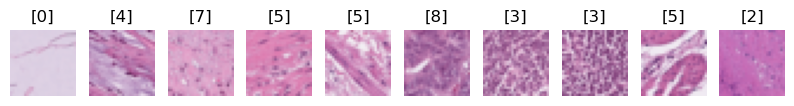

In [4]:
# Let's plot some of the images along with their labels
fig, axes = plt.subplots(1, 10, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(train_images[i])
    ax.set_title(train_labels[i])
    ax.axis("off")
plt.show()

### 4. Prepare data for training

For training, data needs to be fed into the neural network in batches. The process shown here is for Tensorlow/Keras.

In [5]:
# import tensorflow libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [6]:
# convert the labels to one-hot encoded format
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

In [7]:
# Create a data generator object that will be later used to generate batches of (optionally, augmented) images 
train_datagen = ImageDataGenerator() # No augmentation
val_datagen = ImageDataGenerator() # No augmentation
test_datagen = ImageDataGenerator() # No augmentation

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=128)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=128)

### 5. Build a neural network model for classification

We will build a simple neural network model using Keras for image classification.

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)), 
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(9, activation='softmax')
])

# compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        1

### 6. Train the model

In [9]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

704/704 [==============================] - 26s 36ms/step - loss: 1.1631 - accuracy: 0.5674 - val_loss: 0.8357 - val_accuracy: 0.6955


Visualize the training process.

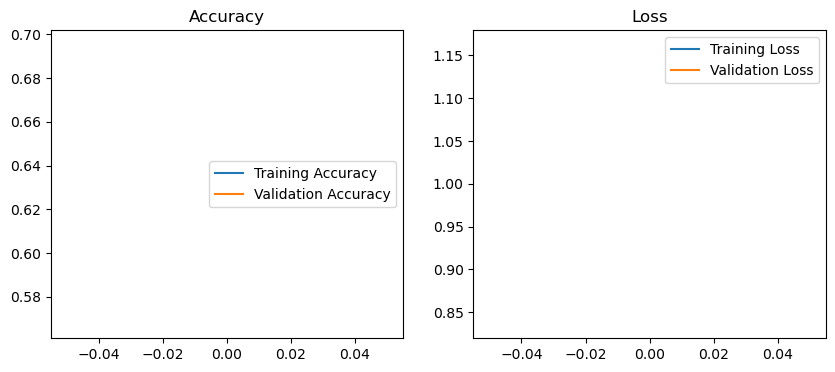

In [10]:
# Let's visualize the training and validation accuracy and loss over the epochs.
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

### 7. Evaluate the results

We will plot a confusion matrix for the test dataset and calculate the accuracy of the model.

In [11]:
# import necessary libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns

# predict the test labels
test_predictions = model.predict(test_images)

# get the predicted labels
test_predictions = np.argmax(test_predictions, axis=1)

# get the true labels
test_true = np.argmax(test_labels, axis=1)

# print the accuracy
print("Accuracy on test set:", np.mean(test_predictions == test_true))

225/225 [==============================] - 1s 2ms/step
Accuracy on test set: 0.731058495821727


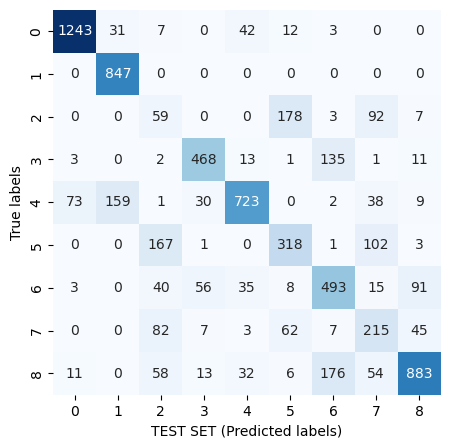

313/313 [==============================] - 1s 2ms/step


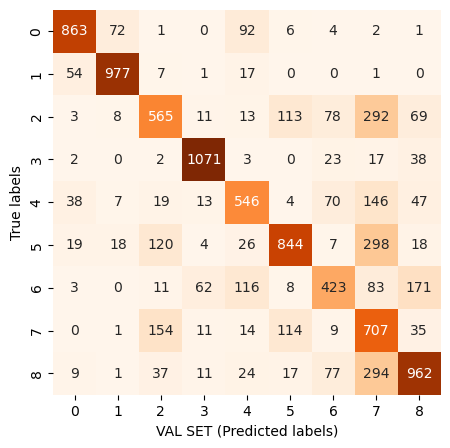

In [13]:
# calculate the confusion matrix
cm = confusion_matrix(test_true, test_preds)

# plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Exercise 2: Using Fiji and DeepImageJ

In this exercise, we will learn how to use Fiji (ImageJ) and deep learning models using plugins like `DeepImageJ` and model repositories such as `Bioimage.io`.

Please follow the instructions in the Workshop slides to complete this exercise.

You'll learn:
- How to download and run Fiji (ImageJ)
- How to install and use DeepImageJ plugin
- How to use Bioimage.io model repository to download pre-trained deep learning models
- How to run deep learning models to your images

**Author's note**: There are many pros and cons of using Fiji and plugins such as DeepImageJ. This is a quick way to get started with deep learning in bioimaging without writing any code. It is a good way to stay up-to-date on prevalant tasks and models in the BioImaging community. However, you will soon realize that many of these models become outdated and incompatible (because of various software and environment that end users use) quickly and are plagued with overly-complicated code because they want to generalize to a larger audience. As you will learn in this workshop, it is possible to write simple, clean and effective Python code for your own project using libraries like TensorFlow, PyTorch, etc. to carry out similar tasks.

## Exercise 3: Image Segmentation with U-Net (Google Colab)

In this exercise, we will build a U-Net model for image segmentation using the Kvasir-SEG dataset, which contains gastrointestinal polyp images and their corresponding segmentation masks.

### Step 1: Importing Libraries

First, let's import the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
import cv2
import urllib
import zipfile

### Step 2: Downloading and Extracting the Dataset

We will use the Kvasir-SEG dataset for this exercise. Let's download and extract the dataset.

In [2]:
# Download the Kvasir-SEG dataset to local storage
url = "https://datasets.simula.no/downloads/kvasir-seg.zip"
zip_path = "Kvasir-SEG.zip"
data_path = ""

if not os.path.exists(zip_path):
    urllib.request.urlretrieve(url, zip_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

### Step 3: Loading the Dataset

Let's load the images and masks from the extracted dataset.

In [3]:
# define paths for images and masks
image_dir = os.path.join(data_path, 'Kvasir-SEG/images')
mask_dir = os.path.join(data_path, 'Kvasir-SEG/masks')

# create empty lists to store images and masks
images = []
masks = []

# loop through each file in the images and masks directories, read the images and masks, and store them in the lists
for image_name in os.listdir(image_dir):
    
    image_path = os.path.join(image_dir, image_name)
    mask_path = os.path.join(mask_dir, image_name)

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image, (64, 64))
    mask = cv2.resize(mask, (64, 64))

    images.append(image)
    masks.append(mask)

# convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Normalize images
images = images / 255.0
masks = masks / 255.0
masks = masks.reshape(-1, 64, 64, 1) # add an extra dimension for the channel

# Split the data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

# Check the shapes to ensure they are correct
print(f'Train images shape: {train_images.shape}')
print(f'Validation images shape: {val_images.shape}')
print(f'Train masks shape: {train_masks.shape}')
print(f'Validation masks shape: {val_masks.shape}')

Train images shape: (800, 64, 64, 3)
Validation images shape: (200, 64, 64, 3)
Train masks shape: (800, 64, 64, 1)
Validation masks shape: (200, 64, 64, 1)


### Step 4: Building the U-Net Model

We will build a U-Net model for image segmentation.

In [4]:
def unet_model(input_size=(64, 64, 3)):
    
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)

    # Decoder
    up5 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop4))
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(conv5)

    up6 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(32, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(conv7)
    
    conv8 = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=conv8)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = unet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                              

### Step 5: Training the Model

Now, we will train the model using the training data.

In [13]:
history = model.fit(
    train_images, train_masks,
    epochs=25,
    batch_size=32,
    validation_data=(val_images, val_masks)
)

ValueError: `y` argument is not supported when using `keras.utils.Sequence` as input.

### Step 6: Evaluating the Model

Finally, we will evaluate the model's performance on the validation data.

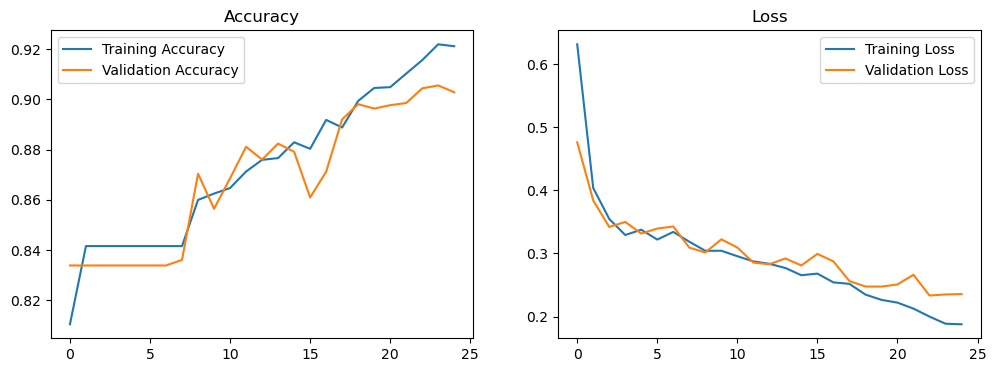

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

### Visualizing Segmentation Results

Let's visualize some example segmentation results.

7/7 [==============================] - 0s 49ms/step


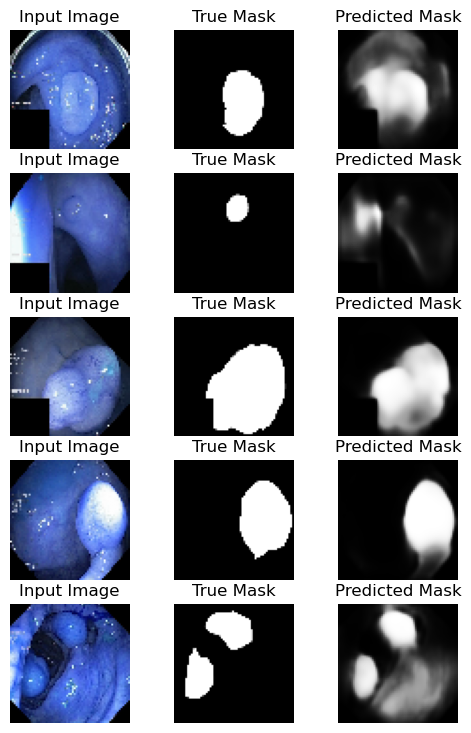

In [11]:
def display_results(model, images, labels, num_samples=5):
    predictions = model.predict(images)
    fig, axes = plt.subplots(num_samples, 3, figsize=(6, 9))

    for i in range(num_samples):
        axes[i, 0].imshow(images[i].reshape(64, 64, 3))
        axes[i, 0].set_title('Input Image')
        axes[i, 1].imshow(labels[i].reshape(64, 64), cmap='gray')
        axes[i, 1].set_title('True Mask')
        axes[i, 2].imshow(predictions[i].reshape(64, 64), cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        for ax in axes[i]:
            ax.axis('off')

    plt.show()

display_results(model, val_images, val_masks)

## Exercise 4: Denoising using CARE (via ZeroCostDL4Mic)

In this exercise, we will use the CARE (Content-Aware Image Restoration) neural network to denoise biomedical images. We will follow the Notebook implementation of ZeroCostDL4Mic, a platform that provides free access to deep learning models for bioimaging.

1. Please click here to open the ZeroCostDL4Mic notebook in a new Google Colab window: [CARE_2D_ZeroCostDL4Mic.ipynb](https://colab.research.google.com/github/HenriquesLab/ZeroCostDL4Mic/blob/master/Colab_notebooks/CARE_2D_ZeroCostDL4Mic.ipynb)
2. Delete the current Google Colab session. Go to `Runtime > Manage Sessions` and delete the current session. This is because you can only run one session at a time on the free tier.
3. Create a copy of the ZeroCostDL4Mic notebook by going to `File > Save a copy in Drive`.
4. Follow the instructions in the ZeroCostDL4Mic notebook.

### Steps to upload denoising dataset to your Google Drive.
1. Click this link to download the dataset: [Denoising_Dataset.zip](https://zenodo.org/records/5750174/files/Denoising_Dataset.zip?download=1) to your local computer.
2. Extract the downloaded zip file to your local computer.
3. In your Google Drive page in your browser, go to `+ New > Folder upload` and upload the extracted `Denoising_Dataset` folder.

### Things to change / enter in the `CARE_2D_ZeroCostDL4Mic.ipynb` notebook:

You might need to adjust these based on where you uploaded the dataset in your Google Drive.
```
Training_source: /content/gdrive/MyDrive/Denoising_Dataset/Training/low
Training_target: /content/gdrive/MyDrive/Denoising_Dataset/Training/high
model_name: denoising_model
model_path: /content/gdrive/MyDrive/Denoising_Dataset/Results
number_of_epochs: 1 # You can increase this number if you have time or if you are connected to the GPU kernel

Use_Data_augmentation: # check this box
```